In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from numpy.random import seed
seed(20)  ##15 for left canal
import google.protobuf

import gast
import tensorflow as tf
tf.random.set_seed(20) ##32 for training 1
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12656464808359311040
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40074543104
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9813295375914510100
physical_device_desc: "device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0"
xla_global_id: 416903419
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-08-24 17:33:29.268968: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 17:33:30.199681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0
2023-08-24 17:33:30.209793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


True

In [2]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import cv2
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage

def dice_coef(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

def compute_dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

def get_full_scan(folder_path):

    files_List  = glob.glob(folder_path + '/**/*.dcm', recursive = True)
    itkimage = sitk.ReadImage(files_List[0])
    rows = int(itkimage.GetMetaData('0028|0010'))
    cols = int(itkimage.GetMetaData('0028|0011'))
    
    a = itkimage.GetMetaData('0028|0030')
    c = itkimage.GetMetaData('0018|0050')
    #print('z spacing ',c)
    #print('xy spacing: ',a)
    mn = 1000
    mx = 0
    for file in (files_List):
        itkimage = sitk.ReadImage(file)
        mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
        mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
    full_scan = np.ndarray(shape=(mx-mn+1,rows,cols), dtype=float, order='F')
    for file in (files_List):
        img, n = dcm_image(file)
        n = int(n)
        full_scan[n-mn,:,:] = img[0,:,:]
    return full_scan

def dcm_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    ins = float(itkimage.GetMetaData('0020|0013'))
    return numpyImage, ins

import copy
def get_normalized(scann,mn,mx):
    scan = copy.copy(scann)
    mn = max(mn,np.amin(scan))
    mx = min(mx,np.amax(scan))
    np.clip(scan, mn, mx, out=scan)
    d = mx - mn
    scan = (scan-mn)/d
    return scan

def res_scan(nscan,image_size):

    depth_factor = image_size[0]/nscan.shape[0]
    width_factor = image_size[2]/nscan.shape[2]
    height_factor = image_size[1]/nscan.shape[1]
    nscann = copy.copy(nscan)
    nscann = ndimage.zoom(nscann, (depth_factor, height_factor, width_factor), order=1)
    return nscann

def res_mask(nmask,image_size):
    depth_factor = image_size[0]/nmask.shape[0]
    width_factor = image_size[2]/nmask.shape[2]
    height_factor = image_size[1]/nmask.shape[1]

    nmaskk = copy.copy(nmask)
    nmaskk = ndimage.zoom(nmaskk, (depth_factor, height_factor, width_factor), order=1, mode = 'nearest')
    return nmaskk

In [15]:
maskpath = sorted(glob.glob(r"C:\Users\Rabeea\Desktop\manifest-1599750808610\TCIA_pancreas_labels-02-05-2017\TCIA_pancreas_labels-02-05-2017/*.gz", recursive = True))
imgpath = sorted(glob.glob(r"C:\Users\Rabeea\Desktop\manifest-1599750808610\Pancreas-CT/*/**/***"))
len(maskpath)
tr = 50
val = 10
ts = 20
random.Random(42).shuffle(imgpath)
random.Random(42).shuffle(maskpath)
trainpath = imgpath[:tr]
trainpath_m = maskpath[:tr]
valpath = imgpath[tr:tr+val]
valpath_m = maskpath[tr:tr+val]
testpath = imgpath[tr+val:]
testpath_m = maskpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))
print(valpath[:3],valpath_m[:3])

80 50 10 20
['C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\Pancreas-CT\\PANCREAS_0001\\11-24-2015-PANCREAS0001-Pancreas-18957\\Pancreas-99667', 'C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\Pancreas-CT\\PANCREAS_0053\\11-24-2015-PANCREAS0053-Pancreas-20037\\Pancreas-60927', 'C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\Pancreas-CT\\PANCREAS_0077\\11-24-2015-PANCREAS0077-Pancreas-62521\\Pancreas-39769'] ['C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\TCIA_pancreas_labels-02-05-2017\\TCIA_pancreas_labels-02-05-2017\\label0001.nii.gz', 'C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\TCIA_pancreas_labels-02-05-2017\\TCIA_pancreas_labels-02-05-2017\\label0053.nii.gz', 'C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\TCIA_pancreas_labels-02-05-2017\\TCIA_pancreas_labels-02-05-2017\\label0077.nii.gz']


In [16]:
testpath[1]

'C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\Pancreas-CT\\PANCREAS_0013\\11-24-2015-PANCREAS0013-Pancreas-31532\\Pancreas-27599'

In [17]:
tt = []
for t in testpath:
    tt.append(t + '_1')
    tt.append(t + '_2')
testpath = tt

tt = []
for t in testpath_m:
    tt.append(t + '_1')
    tt.append(t + '_2')
testpath_m = tt

In [22]:
testpath_m[2]#[:-2]


'C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\TCIA_pancreas_labels-02-05-2017\\TCIA_pancreas_labels-02-05-2017\\label0013.nii.gz_1'

In [4]:
tt = []
for t in trainpath:
    tt.append(t + '_1')
    tt.append(t + '_2')
trainpath = tt

tt = []
for t in valpath:
    tt.append(t + '_1')
    tt.append(t + '_2')
valpath = tt


tt = []
for t in trainpath_m:
    tt.append(t + '_1')
    tt.append(t + '_2')
trainpath_m = tt

tt = []
for t in valpath_m:
    tt.append(t + '_1')
    tt.append(t + '_2')
valpath_m = tt


tt = []
for t in testpath:
    tt.append(t + '_1')
    tt.append(t + '_2')
testpath = tt

tt = []
for t in testpath_m:
    tt.append(t + '_1')
    tt.append(t + '_2')
testpath_m = tt


print(len(imgpath), len(trainpath), len(valpath), len(testpath))

80 100 20 40


In [4]:
from tensorflow.keras.utils import Sequence


def parse_image(img_path, image_size):
    
    img = get_full_scan(img_path[:-2])
    img = get_normalized(img,-125,275) 
    img = res_scan(img, image_size)
    if '_1' in img_path:
        img = img[:int(image_size[0]/2),:,:]
    else:
        img = img[int(image_size[0]/2):,:,:]
    #mn = np.amin(img)
    #mx = np.amax(img)
    #d = mx - mn
    #img = (img-mn)/d
    img = np.expand_dims(img, axis=3)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img

def parse_mask(mask_path, image_size):
    mask = nib.load(mask_path[:-2])
    mask = mask.get_fdata()
    mask = np.swapaxes(mask,0,2)
    mask = res_mask(mask, image_size)
    if '_1' in mask_path:
        mask = mask[:int(image_size[0]/2),:,:]
    else:
        mask = mask[int(image_size[0]/2):,:,:]
    mask = np.expand_dims(mask, axis=3)
    
    mask = np.where(mask>0,1,mask)
    mask = mask.astype(np.uint8)
    return mask

class DataGen(Sequence):
    def __init__(self, image_size, images_path,mask_path, batch_size=112):
        self.image_size = image_size
        self.images_path = images_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size/112 > len(self.images_path):
            self.batch_size = len(self.images_path) - (index*self.batch_size/112)

        images_path = self.images_path[int(index*self.batch_size/112) : int((index+1)*self.batch_size/112)]
        mask_path = self.mask_path[int(index*self.batch_size/112) : int((index+1)*self.batch_size/112)]

        #images_batch = np.empty((self.batch_size,image_size[0],image_size[1],image_size[2],3))
        #images_batch = np.empty((self.batch_size,image_size[1],image_size[2],1))
        #masks_batch = np.empty((self.batch_size,image_size[1],image_size[2],1),dtype = 'uint8')
        #print(len(images_path))
        for i in range(len(images_path)):
            # Read image and mask
            images_batch= parse_image(images_path[i], self.image_size)
            masks_batch = parse_mask(mask_path[i], self.image_size)

        #return np.array(images_batch), np.array(masks_batch)
        return images_batch,masks_batch

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size/112)))
    

In [5]:
image_size = (224,256,256)
batch_size = 112

epochs = 350

train_steps = len(trainpath)*112//batch_size
valid_steps = len(valpath)*112//batch_size

## Generator
train_gen = DataGen(image_size, trainpath,trainpath_m,batch_size=batch_size)
valid_gen = DataGen(image_size,valpath, valpath_m, batch_size=batch_size)

In [8]:
t = train_gen.__getitem__(0)[0]
p = train_gen.__getitem__(0)[1]


In [9]:
t.shape

(112, 256, 256, 1)

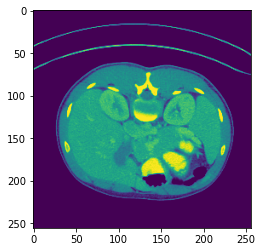

In [10]:
plt.imshow(t[110,:,:,0])

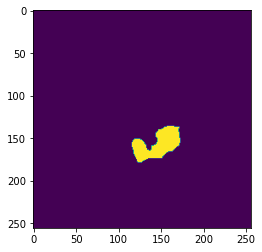

In [11]:
plt.imshow(p[110,:,:,0])

In [12]:
np.unique(p)

array([0, 1], dtype=uint8)

In [3]:

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from einops.layers.tensorflow import Rearrange
import keras_nlp
#import tensorflow_datasets as tfds

def unet(pretrained_weights = None,input_size = (256,256,1), f = 64, embedding_dim = 4, dim = 8, heads = 2):
    inputs = Input(input_size)
    scale = dim ** -0.5
    
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(f*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(f*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up = Conv2D(f*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge = concatenate([conv4,up], axis = 3)
    conv = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)

    up = Conv2D(f*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv))
    merge = concatenate([conv3,up], axis = 3)
    conv = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)

    up = Conv2D(f*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv))
    merge = concatenate([conv2,up], axis = 3)
    conv = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)

    up = Conv2D(f, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(1, 1, activation = 'sigmoid')(conv)

    model = Model(inputs = inputs, outputs = conv)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss="sparse_categorical_crossentropy", metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from einops.layers.tensorflow import Rearrange
import keras_nlp
#import tensorflow_datasets as tfds

def unet(pretrained_weights = None,input_size = (256,256,1), f = 64, embedding_dim = 4, dim = 8, heads = 2):
    inputs = Input(input_size)
    scale = dim ** -0.5
    
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(f*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(f*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up = Conv2D(f*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge = concatenate([conv4,up], axis = 3)
    conv = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)

    up = Conv2D(f*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv))
    merge = concatenate([conv3,up], axis = 3)
    conv = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)

    up = Conv2D(f*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv))
    merge = concatenate([conv2,up], axis = 3)
    conv = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)

    up = Conv2D(f, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(1, 1, activation = 'sigmoid')(conv)

    model = Model(inputs = inputs, outputs = conv)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss="sparse_categorical_crossentropy", metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [4]:
a= unet()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

2023-08-24 17:34:26.619595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0
/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 256)  0          ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 512)  1180160     ['max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 512)  2359808     ['conv2d_6[0][0]']               
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 512)  0          ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 1024  4719616     ['max_pooling2d_3[0][0]']        
          

In [9]:
a= Unet3D((112,256,256,1),1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 256, 2  0           []                               
                                56, 1)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 224, 256, 25  224         ['input_1[0][0]']                
                                6, 8)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 256, 25  32         ['conv3d[0][0]']                 
 alization)                     6, 8)                                                         

                                                                                                  
 conv3d_10 (Conv3D)             (None, 56, 64, 64,   27680       ['batch_normalization_9[0][0]']  
                                32)                                                               
                                                                                                  
 batch_normalization_10 (BatchN  (None, 56, 64, 64,   128        ['conv3d_10[0][0]']              
 ormalization)                  32)                                                               
                                                                                                  
 up_sampling3d_1 (UpSampling3D)  (None, 112, 128, 12  0          ['batch_normalization_10[0][0]'] 
                                8, 32)                                                            
                                                                                                  
 conv3d_11

C:\Users\Rabeea\anaconda3\envs\beea4\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
a = unet(pretrained_weights = r"C:/Users/Rabeea/JupyterN/logs/unet_2d/4layers_e4_350.h5")
a.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss=dice_loss, metrics = ['accuracy', dice_coef])
a.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 8)  0           ['conv2d_1[0][0]']           

C:\Users\Rabeea\anaconda3\envs\beea4\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = r"C:/Users/Rabeea/JupyterN/logs/unet_2d/4layers_e4_350.h5"
tensorboard = TensorBoard(log_dir=r"C:/Users/Rabeea/JupyterN/logs/unet_2d/4layers_e4_350", histogram_freq=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]

In [16]:
history = a.fit(train_gen,
                      validation_data=valid_gen,epochs=epochs,callbacks=callbacks_list)

Epoch 1/350
100/100 [==============================] - 910s 9s/step - loss: 0.9656 - accuracy: 0.9484 - dice_coef: 0.0344 - val_loss: 0.9010 - val_accuracy: 0.9942 - val_dice_coef: 0.0990
Epoch 2/350
100/100 [==============================] - 869s 9s/step - loss: 0.8661 - accuracy: 0.9967 - dice_coef: 0.1339 - val_loss: 0.8526 - val_accuracy: 0.9979 - val_dice_coef: 0.1474
Epoch 3/350
100/100 [==============================] - 868s 9s/step - loss: 0.8320 - accuracy: 0.9978 - dice_coef: 0.1680 - val_loss: 0.8339 - val_accuracy: 0.9980 - val_dice_coef: 0.1661
Epoch 4/350
100/100 [==============================] - 867s 9s/step - loss: 0.8112 - accuracy: 0.9978 - dice_coef: 0.1888 - val_loss: 0.8058 - val_accuracy: 0.9980 - val_dice_coef: 0.1942
Epoch 5/350
100/100 [==============================] - 870s 9s/step - loss: 0.7899 - accuracy: 0.9978 - dice_coef: 0.2101 - val_loss: 0.7791 - val_accuracy: 0.9973 - val_dice_coef: 0.2209
Epoch 6/350
100/100 [==============================] - 873s 

100/100 [==============================] - 875s 9s/step - loss: 0.1723 - accuracy: 0.9991 - dice_coef: 0.8277 - val_loss: 0.3262 - val_accuracy: 0.9987 - val_dice_coef: 0.6738
Epoch 88/350
100/100 [==============================] - 878s 9s/step - loss: 0.1690 - accuracy: 0.9991 - dice_coef: 0.8310 - val_loss: 0.3020 - val_accuracy: 0.9987 - val_dice_coef: 0.6980
Epoch 89/350
100/100 [==============================] - 881s 9s/step - loss: 0.1676 - accuracy: 0.9991 - dice_coef: 0.8324 - val_loss: 0.3339 - val_accuracy: 0.9987 - val_dice_coef: 0.6661
Epoch 90/350
100/100 [==============================] - 880s 9s/step - loss: 0.1649 - accuracy: 0.9991 - dice_coef: 0.8351 - val_loss: 0.3170 - val_accuracy: 0.9986 - val_dice_coef: 0.6830
Epoch 91/350
100/100 [==============================] - 879s 9s/step - loss: 0.1664 - accuracy: 0.9991 - dice_coef: 0.8336 - val_loss: 0.3123 - val_accuracy: 0.9986 - val_dice_coef: 0.6877
Epoch 92/350
100/100 [==============================] - 879s 9s/step

100/100 [==============================] - 876s 9s/step - loss: 0.1094 - accuracy: 0.9994 - dice_coef: 0.8906 - val_loss: 0.2988 - val_accuracy: 0.9987 - val_dice_coef: 0.7012
Epoch 174/350
100/100 [==============================] - 875s 9s/step - loss: 0.1078 - accuracy: 0.9994 - dice_coef: 0.8922 - val_loss: 0.3135 - val_accuracy: 0.9988 - val_dice_coef: 0.6865
Epoch 175/350
100/100 [==============================] - 877s 9s/step - loss: 0.1111 - accuracy: 0.9994 - dice_coef: 0.8889 - val_loss: 0.2944 - val_accuracy: 0.9988 - val_dice_coef: 0.7056
Epoch 176/350
100/100 [==============================] - 876s 9s/step - loss: 0.1076 - accuracy: 0.9994 - dice_coef: 0.8924 - val_loss: 0.2917 - val_accuracy: 0.9988 - val_dice_coef: 0.7083
Epoch 177/350
  6/100 [>.............................] - ETA: 12:06 - loss: 0.1108 - accuracy: 0.9992 - dice_coef: 0.8892

KeyboardInterrupt: 

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [25]:
test_gen = DataGen(image_size,testpath, testpath_m, batch_size=112)
tr_dice=[]
for k in tqdm(range(len(testpath))):
    #try:
    y_pred=a.predict(test_gen.__getitem__(k)[0])
    y_pred_argmax=np.where(y_pred>0.48,1,0)
    true_msk=test_gen.__getitem__(k)[1]
    #if sum(sum(sum(true_msk)))>0:

    tr_dice.append(compute_dice(y_pred_argmax, true_msk))
#     except:
#         print(k)
#         break
np.mean(tr_dice)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]C:\Users\Rabeea\AppData\Local\Temp\ipykernel_21968\3900323782.py:72: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
C:\Users\Rabeea\AppData\Local\Temp\ipykernel_21968\3900323782.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/rele

0.5984188952817393

In [ ]:
##>0.53 : 59.66
